
# Music Genre Classification based on Audio Analysis

##### Last updated on December 15th, 2022 by Matthew Lynch and Kalonji Harrington


## What are music genres?

Around the world there are countless different [music genres](https://en.wikipedia.org/wiki/Music_genre). Shaped by cultural influences and a complex history, genres  can generally be thought of as categories of similar music. In a given genre, music typically follows a set of conventions that ultimately form the distinctive elements of a particular style. Some genres might heavily rely on vocals to cary the melody of a song while others emphasize the rhythm instead by utilizing powerful drumlines and bass guitars. While there are main categories such as "pop", "country", and "rock" to name a few, these genres also have numerous sub-genres and fusions that express different stylings and variations that have developed over time. The [MusicMap](https://musicmap.info/) project presents a visualization of the geneology of music, emphasizing the musical relations and history between each genre. Through visualizations like the MusicMap, it becomes easy to undertsand just how interconnected and blended music genres are.

<img src="MusicMap.png" alt="Visualization of music genres provided by MusicMap" style="width: 1200px;"/>

## How do we classify music genres?

If someone were tasked with categorizing the genre of a given track, the answer may appear obvious. When distinguishing between genres like "country" and "metal" someone could point to the song's tempo, the instruments used, or even the musical key of the song as justification for the track being labeled in one genre or another. The answer appears intuitive at first, but as sub-genres are compared, it becomes increasingly difficult for someone to distinguish between genres like "punk" and "classical rock" and if someone isn't an avid listener of techno music, it might be borderline impossible to tell the genres of "electro" apart from "house." Over time, more niche genres have appeared while others have blended together and the resulting connections can make it incredibly difficult to accurately discern one genre from another.

## So if it can be difficult to classify genres, what's the point?

Although it may be difficult, classifying music genres can help immensely with musical comprehension and recognition. Even if the categorization of the music isn’t definitive, having close approximations for the genre can be beneficial for describing and sharing the music with others. If someone is told that a song belongs to the “reggae” genre, then the listener can expect the aforementioned conventions to better appreciate the track. Much like how taxonomy is beneficial for biologists, musical classification can help people understand the common traits between music. With properly classified music, it can be easy for people to discover new songs they like as someone can search for music from the same genre or related genres.

### So which musical qualities can be used to classify musical genres? 

Because of the difficulty in classifying specific genres of music, this project aims to utilize Machine Learning methods to perform the categorization of music genres. Hopefully this analysis will reveal which musical qualities are integral for specific genres which will gather some insight as to the conventions that shape modern music.


## Billboard Hot 100

To understand how Machine Learning methods could be used to classify musical genres, we first needed to gather data. We chose to use [Billboard charts](https://www.billboard.com/charts/) as we wanted data on the most popular songs within the United States without relying on a specific streaming service. The idea was to chose songs from the top charts to sample songs that are popular within their genre; a popular rap song might have more qualities that make it emblematic of rap compared to a song that wasn't popular. While music streaming services keep track of how often a song is played, managing to collect the total number of times a given track has been played on different services would be an incredibly time consuming task. When searching for an alternative, we found [Billboard Magazine](https://www.billboard.com/) which focuses its brand on constructing charts and reporting on music news and trends across different genres of music. The Billboard Hot 100 acts as a [music industry standard record chart](https://en.wikipedia.org/wiki/Billboard_Hot_100) and provides information taking into considering all of the most common ways to consume music today. The tooltip on the Hot 100 Charts says the following:

> The week’s most popular songs, ranked by audio and video streaming activity on leading digital music services, radio airplay audience impressions based on monitored airplay and sales data, all compiled by Luminate. Audience totals are derived, in part, using certain Nielsen Audio listener estimates.”

They also provide a variety of charts such as the Billboard Global 200, Billboard Global Excluding US, and more.


### Spotify Web Api

After using the Billboard Hot 100 charts to obtain a list of popular songs, we looked for other websites to scrape relevant song data from. After spending some time looking, we ended up deciding to use [Spotify's Web API](https://developer.spotify.com/). The API provides access to user specfic data such as playlists and saved music alongside more general public data, such as information about the tracks Spotify has access to. This project doesn't need user specific information, so only client side authentication was needed.

After creating an account with Spotify, we created a project on the dashboard to obtain the client side credentials needed to access the Web API. With those credentials we were able to use the python library [spotipy](https://spotipy.readthedocs.io/en/2.19.0/#) to run the API within python. For the authentication, we stored the clientID and clientSecretID on our local devices in a file named `config.py` 

If you are trying to run this project yourself, make sure to create a `config.py` on your local device and add your own credentials to it. The `import config` will allow this project to access the credentials and subsequently allow proper requests to the Web API.

The Spotify Web API was used to obtain Spotify's audio analysis data which analyzes samples from a given track and records values for duration, loudness, tempo, time signature, tempo, key, and the mode (minor or major) of the song along with the corresponding confidence values.


## Initial Data Collection

Now with all of the basic information covered, we can now go ahead with obtaining the data. Throughout the project, the dataframes are exported to csv files which are considerably faster to read than manually scraping the data again as there are a lot of weeks in over two decades with each week having 100 songs each.



### Collecting Billboard Top 100 Data

To begin, we first want to scrape the information from the Billboard Hot 100 pages. We're looking to obtain the ranking of each song, the song titles, the artist names, and the number of weeks the song has been in the Hot 100. 

In [8]:
# Import libraries for data collection
import pandas as pd
import requests as rq
from bs4 import BeautifulSoup as bs
import datetime as dt
import re
SCRAPING = False

# Returns a formatted string from a datetime to use when scraping Billboard charts
def format_datetime(datetime):
    return str(datetime.year).zfill(4) + "-" + str(datetime.month).zfill(2) + "-" + str(datetime.day).zfill(2) 

# Returns a formatted string given a string containing artist name(s)
def format_name(name):
    # Fixes the formatting of the ampersand
    amp = re.sub('&amp;', "&", name)
    # Standardizes ways of featuring an artist to "ft."
    ft = re.sub('(Featuring)|(featuring)|(feat\.?)', "ft.", amp)
    return ft

# Removes html tags from a string
def remove_tags(tag, string):
    tag1 ='<' + tag + '.*?>\s*'
    tag2 = '\s*</' + tag + '.*?>'
    return re.sub(tag2, "", re.sub(tag1, "", string))

# Scrapes data from a specified billboard page in a given period of time
def scrape_billboard(start_date, end_date, page):
    info_list = []
    date = start_date
    # Continues to scrape from new pages until the end date is reached
    while date <= end_date:
        # Access the proper url given the date
        billboard_url = "https://www.billboard.com/"  + page + format_datetime(date) + "/"
        soup = bs(rq.get(billboard_url).content)
        # Look for individual song entries
        charts = soup.find_all("div", class_=re.compile('o-chart-results-list-row-container'))
        for entry in charts:
            # Scrape the data from the chart
            rank = remove_tags("span", str(entry.find("span", class_=re.compile('c-label a-font-primary-bold-l'))))
            title = remove_tags("h3", str(entry.find("h3", class_=re.compile('c-title'))))
            artist = remove_tags("span", str(entry.find("span", class_=re.compile('c-label a-no-trucate'))))
            # Properly format the title and artist for ease of use later
            title = format_name(title)
            artist = format_name(artist)
            # Find Last_Week, Peak_Pos, and Wks_on_Chart info
            search = entry.find_all("span", class_=re.compile('(c-label a-font-primary-m lrv-u-padding-tb-050@mobile-max)|(c-label a-font-primary-bold-l a-font-primary-m@mobile-max u-font-weight-normal@mobile-max)'))
            "c-label a-font-primary-bold-l a-font-primary-m@mobile-max u-font-weight-normal@mobile-max"
            # Grab the data on the weeks on the chart
            weeks = remove_tags("span", str(search[2]))

            # Add the data to the info_list
            page_name = "Weeks_in_" + re.sub('charts/|/', "_", page).strip("_")
            data = {'Rank': rank, 'Title': title, 'Artist': artist, 'Week': date, page_name: weeks}
            info_list.append(data)
        # Increment the date by a week (Billboard's charts are on a weekly basis)
        date += dt.timedelta(days = 7)
    # Return a dataframe from the info_list
    return pd.DataFrame(info_list)

if SCRAPING:
    # Scrape hot-100 data from 01-01-2000 to today
    billboard_data = scrape_billboard(dt.date(2022, 1, 1), dt.date.today(), "charts/hot-100/")
    # Track the first and last week a track enters the hot-100 charts instead of each week that the data is in the hot-100
    billboard_data.insert(5, "First_Week", billboard_data['Week'], False)
    billboard_data.insert(6, "Last_Week", billboard_data['Week'], False)
    billboard_data.drop(columns=['Week'], inplace=True)

    # Export to a csv to save time in subsequent calls
    billboard_data.to_csv("csv/billboard_data_2022.csv")

While we could have used global data instead of the Hot 100, we chose to use the Hot 100 due to the potential musical differences overseas. Different sub-genres based on geographical location exist, with some examples being "uk pop" or "argentinian funk," and examining music on a global scale introduces potential issues if "uk pop" turns out to be radically different from "pop" within the United States. While there is still some overlap with international music appearing on the US Hot 100, the usage of the US Hot 100 should help minimize the variance of the data. It is entirely feasible to look at the different charts instead of the Hot 100 if so desired. The `page` parameter in `scrape_billboard()` allows different charts to be passed using the same function definition.

Additionally, although we haven't finished scraping all of the data (since we haven't used the Spotify Web API just yet), we went ahead and started to format the data just to make additional scraping easier. The Billboard Hot 100 charts formatted ampersands differently, so I replaced their string with a simple ampersand just to make the subsequent regular expressions easier to handle. we also standardized the usage of "Featuring" or "featuring" or "feat." to just be "ft." since consistent expressions are easier to handle.


### Collecting Spotify Data Based On Billboard Data

Now that the data from the Billboard charts has been collected, we can now group the data by the titles (removing duplicate entries) and extract other information using Spotify's API. The grouping is done mainly to prevent the data points from appearing multiple times when we apply machine learning algorithms. This is especially important for supervised learning as we don't want the same data in both the test and training set. Combining repeated entries also helps to save time as otherwise we would be extracting the same information from a song multiple times if it appears on the charts multiple weeks in a row.

In [9]:
# Import libraries for spotipy and the config file needed to authenticate our client
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import config

# Returns an array with all of the analysis data based on the query results given an artist and a song title
def get_audio_analysis(artist, title):
    # Specify the artist to avoid picking a random song
    q = "{} artist:{}".format(title, artist)
    result = sp.search(q, type='track', limit=1)['tracks']['items']
    # Check if the search was sucessful
    if result == []:
        # If the initial search failed, try again specifying w/ the track tag
        q = "track:{} artist:{}".format(title, artist)
        result = sp.search(q, type='track', limit=1)['tracks']['items']
        # Check if it failed again
        if result == []:
            # No result was able to be found
            return [None, None, None, None, None, None, None, None, None, None]
    
    # Get the SpotifyID from the given search (used for uniquely identifying a track)
    if result[0] == None:
        return [None, None, None, None, None, None, None, None, None, None]
    spotify_id = result[0]['id']
    # Try to run the audio analysis (some songs don't have audio analysis yet or don't exist in Spotify's library)
    try:
        analysis = sp.audio_analysis(spotify_id)
    except spotipy.client.SpotifyException:
        # If it failed, no result was found
        return [None, None, None, None, None, None, None, None, None, None]

    # Find the relevant information from the analysis
    duration = analysis['track']['duration']
    loudness = analysis['track']['loudness']
    tempo = analysis['track']['tempo']
    tempo_conf = analysis['track']['tempo_confidence']
    time_sig = analysis['track']['time_signature']
    time_sig_conf = analysis['track']['time_signature_confidence']
    key = analysis['track']['key']
    key_conf = analysis['track']['key_confidence']
    mode = analysis['track']['mode']
    mode_conf = analysis['track']['mode_confidence']
    # Return the array
    return [duration, loudness, tempo, tempo_conf, time_sig, time_sig_conf, key, key_conf, mode, mode_conf]

# Returns an array with all of the features data based on the query results given an artist and a song title
def get_audio_features(artist, title):
    # Specify the artist to avoid picking a random song
    q = "{} artist:{}".format(title, artist)
    result = sp.search(q, type='track', limit=1)['tracks']['items']
    # Check if the search was sucessful
    if result == []:
        # If the initial search failed, try again specifying w/ the track tag
        q = "track:{} artist:{}".format(title, artist)
        result = sp.search(q, type='track', limit=1)['tracks']['items']
        # Check if it failed again
        if result == []:
            # No result was able to be found
            return [None, None, None, None, None, None, None]
    
    # Get the SpotifyID from the given search (used for uniquely identifying a track)
    if result[0] == None:
        return [None, None, None, None, None, None, None]
    spotify_id = result[0]['id']
    # Try to run the audio analysis (some songs don't have audio analysis yet or don't exist in Spotify's library)
    try:
        features = sp.audio_features(spotify_id)
    except spotipy.client.SpotifyException:
        # If it failed, no result was found
        return [None, None, None, None, None, None, None]

    # Find the relevant information from the analysis
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    speechiness = features[0]['speechiness']
    valence = features[0]['valence']
    # Return the array
    return [acousticness, danceability, energy, instrumentalness, liveness, speechiness, valence]

# Returns an array with all of the genres for a given artist (look into updating to get genre per track instead)
def get_genres(artist):
    results = sp.search(q='artist:' + artist, type='artist')
    return results['artists']['items'][0]['genres'] if len(results['artists']['items']) > 0 else None

# Read the billboard data and drop the extra row from the index
billboard_data = pd.read_csv("csv/billboard_data_2022.csv").iloc[:, 1:]

# Group the data properly using the specified aggregation functions
aggregation_functions = {'Rank': "min", 'Weeks_in_hot-100': "max", 'First_Week': "min", 'Last_Week': "max"}
spotify_data = billboard_data.groupby(['Title', 'Artist']).aggregate(aggregation_functions).reset_index()

# Effectively relabel the Rank row as Top Rank
spotify_data.insert(0, "Top_Rank", spotify_data['Rank'], False)
spotify_data.drop(columns=['Rank'], inplace=True)

# Create an instance of spotipy and store the authentication token with the client credential manager
authentication = SpotifyClientCredentials(client_id=config.cid, client_secret=config.csecret)
sp = spotipy.Spotify(client_credentials_manager=authentication)

if SCRAPING:
    # Declare empy lists for each variable
    # audio analysis - 10
    duration_list = []
    loudness_list = []
    tempo_list = []
    tempo_conf_list = []
    time_sig_list = []
    time_sig_conf_list = []
    key_list = []
    key_conf_list =[]
    mode_list = []
    mode_conf_list = []
    # audio features - 7
    acousticness_list = []
    danceability_list = []
    energy_list = []
    instrumentalness_list = []
    liveness_list = []
    speechiness_list = []
    valence_list = []
    # Genres
    artist_genre_list = []

    # Run the analysis for each unique title in the dataset
    for index, row in spotify_data.iterrows():
        # Create a list of artists, removing all other characters
        string = re.sub('\(|\)', ", ", re.sub('\s+((ft\.)|&|X|x|(\+)|/)\s+', ", ", row['Artist'])).strip(', ')
        artist_list = string.split(",")

        # Try running the analysis until a result if found (sometimes searching an artist wouldn't yield proper results)
        # i.e. "Leave the Door Open" by Silk Sonic, Bruno Mars, ... would only produce a result if Bruno Mars was used
        values = [None, None, None, None, None, None, None, None, None, None]
        more_values = [None, None, None, None, None, None, None]
        for artist in artist_list:
            if values == [None, None, None, None, None, None, None, None, None, None]:
                # Remove parenthesis from the title to avoid the title being too long
                # This was an issue with a Taylor Swift's Christmas Tree Farm (Old Timey Version)
                def_artist = artist
                values = get_audio_analysis(def_artist, re.sub('\(.*\)', "", row['Title']))
                more_values = get_audio_features(def_artist, re.sub('\(.*\)', "", row['Title']))
        
        # Add the results from the analysis to the lists
        duration_list.append(values[0])
        loudness_list.append(values[1])
        tempo_list.append(values[2])
        tempo_conf_list.append(values[3])
        time_sig_list.append(values[4])
        time_sig_conf_list.append(values[5])
        key_list.append(values[6])
        key_conf_list.append(values[7])
        mode_list.append(values[8])
        mode_conf_list.append(values[9])
        acousticness_list.append(more_values[0])
        danceability_list.append(more_values[1])
        energy_list.append(more_values[2])
        instrumentalness_list.append(more_values[3])
        liveness_list.append(more_values[4])
        speechiness_list.append(more_values[5])
        valence_list.append(more_values[6])
        # Get genres
        genres = get_genres(def_artist)
        artist_genre_list.append(genres)

    # Add the data to the dataframe
    spotify_data.insert(6, "Duration", duration_list, False)
    spotify_data.insert(7, "Loudness", loudness_list, False)
    spotify_data.insert(8, "Tempo", tempo_list, False)
    spotify_data.insert(9, "Tempo_Confidence", tempo_conf_list, False)
    spotify_data.insert(10, "Meter", time_sig_list, False)
    spotify_data.insert(11, "Meter_Confidence", time_sig_conf_list, False)
    spotify_data.insert(12, "Key", key_list, False)
    spotify_data.insert(13, "Key_Confidence", key_conf_list, False)
    spotify_data.insert(14, "Mode", mode_list, False)
    spotify_data.insert(15, "Mode_Confidence", mode_conf_list, False)
    spotify_data.insert(16, "Acousticness", acousticness_list, False)
    spotify_data.insert(17, "Danceability", danceability_list, False)
    spotify_data.insert(18, "Energy", energy_list, False)
    spotify_data.insert(19, "Instrumentalness", instrumentalness_list, False)
    spotify_data.insert(20, "Liveness", liveness_list, False)
    spotify_data.insert(21, "Speechiness", speechiness_list, False)
    spotify_data.insert(22, "Valence", valence_list, False)
    spotify_data.insert(23, "Artist_Genres", artist_genre_list, False)

    # Export the spotify data to a csv
    spotify_data.to_csv("csv/spotify_data_2022.csv")

There were a few problems that we encountered when working on using the Spotify Web API to query results. The first issue was when songs that were on Spotify weren't being properly found. Some songs like *Leave The Door Open* by Bruno Mars, Anderson .Paak, and Silk Sonic had some issues due to how complicated the original artist string was. Directly imported from the Billboard charts, the artist strings for each song could be formatted in multiple different ways. After running the below code, we were able to find patterns in songs that failed to properly query. The solution was converting the artists strings into a list of individual artists who are credited for the song and searching multiple times with each artist to maximize the chance that the correct song is chosen. Another similar issue we noticed was with *Christmas Tree Farm (Old Timey Version)* by Taylor Swift as the parenthesis made the query too long for the API to properly handle.

Additionally some songs don't have the audo analysis available in Spoity's API. Some songs like Camila Cabello's *I'll Be Home for Christmas* is only available on Amazon Music and other songs like Shawn Mendes' *Lost in Japan* didn't have an available audio analysis in the API and returned:

`HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/0BXTqB4It8UM09lCaIY3Jk with Params: {} returned 404 due to analysis not found`

In [10]:
# Read in the Spotify and Billboard data combined
df = pd.read_csv("csv/spotify_data_2022.csv").iloc[:, 1:]
# Create a dataframe with only the missing values
null_data = df[df.isnull().any(axis=1)]

# Print info about missing data
print("Total number of tracks: " + str(len(df.index)))
print("Total number of tracks w/ missing data: " + str(len(null_data.index)))
print("Percentage of data with complete data: " + str(100*(1- len(null_data.index)/len(df.index))) + "%")

# Drop the missing data
df = df.dropna()

# Display some of the missing songs
null_data.head(10)

Total number of tracks: 711
Total number of tracks w/ missing data: 10
Percentage of data with complete data: 98.59353023909986%


,Top_Rank,Title,Artist,Weeks_in_hot-100,First_Week,Last_Week,Duration,Loudness,Tempo,Tempo_Confidence,...,Mode,Mode_Confidence,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Speechiness,Valence,Artist_Genres
41,75,At The End Of A Bar,Chris Young With Mitchell Tenpenny,6,2022-07-30,2022-09-03,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,78,Bubbly,Young Thug With Drake & Travis Scott,12,2022-01-01,2022-01-15,165.06667,-7.572,129.011,0.733,...,0.0,0.362,0.0536,0.910,0.585,0.000000,0.1270,0.2570,0.599,NaN
104,50,Chasing After You,Ryan Hurd With Maren Morris,30,2022-01-15,2022-01-15,207.97379,-6.395,131.912,0.486,...,1.0,0.557,0.7230,0.596,0.679,0.000000,0.1160,0.0394,0.479,NaN
321,13,It's Beginning To Look A Lot Like Christmas,Perry Como And The Fontane Sisters With Mitche...,13,2022-01-01,2022-12-03,155.93333,-12.250,112.874,0.507,...,1.0,0.608,0.7600,0.724,0.276,0.000000,0.1160,0.0599,0.718,NaN
394,37,Meet Me At Our Spot,THE ANXIETY: WILLOW & Tyler Cole,26,2022-01-01,2022-03-19,162.68000,-7.930,94.995,0.185,...,1.0,0.576,0.0153,0.773,0.470,0.000193,0.0851,0.0299,0.399,NaN
405,47,Monster Mash,"Bobby ""Boris"" Pickett And The Crypt-Kickers",39,2022-11-12,2022-11-12,161.50667,-14.980,207.832,0.061,...,0.0,0.414,0.5740,0.391,0.366,0.101000,0.1410,0.0392,0.786,NaN
445,98,Oklahoma Smoke Show,Zach Bryan,1,2022-10-08,2022-10-08,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['oklahoma country']
522,35,Santa Baby,Eartha Kitt With Henri Rene And His Orchestra,3,2022-01-01,2022-01-08,206.06667,-12.346,84.485,0.625,...,1.0,0.510,0.9020,0.700,0.139,0.000000,0.1850,0.0607,0.490,NaN
596,22,Thank God,Kane Brown With Katelyn Brown,11,2022-09-24,2022-12-03,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
690,47,Wishful Drinking,Ingrid Andress With Sam Hunt,20,2022-07-16,2022-11-26,194.54498,-7.317,79.018,0.073,...,1.0,0.497,0.2890,0.678,0.528,0.000000,0.0734,0.0551,0.614,NaN


As we can see, the data is only missing 10 out of 711 different tracks. In the future we may go back and find other methods of accessing the missing data using other APIs, though we would need to adjust for the potential differences in how the missing data is calculated in comparison to Spotify's audio analysis. For now, we just opted for dropping the entries with missing data from the table.

## Machine Learning

### Data Representation

We first apply some methods to group the genres based on the artist genres. Unfortunately the Spotify API doesn't inlcude any methods for obtaining the genre of a particular song. However, they do provide a list of genres for each artist. While it isn't guaranteed that each artist only produces music within one genre, we decided to use the artist genre as a rough approximation for the genre of a given song. In the future, determining an alternative method of finding the genre of a song could improve the accuracy of our methods, but for now as we are applying the machine learning algorithms to just the broader categorizations of genres, using the artist's genres as an approximation should be a sufficient approximation.

In [11]:
# Returns a list with genres from the artist_genre categorized into broader categories based on keywords 
def group_genres(column_input):
    column = []
    for row in column_input:
        # Parse the artist_genre string to get the individual genres
        genre_list = re.findall(r"'([^']*)'", row)
        found_genre = False
        for genre in genre_list:
            # Continue until a suitable match for the genre is found
            if found_genre:
                break
            # Check each given genre to see if it contains a specific keyword
            if "pop" in genre:
                column.append("Pop")
                found_genre = True
            elif "country" in genre or "hillbilly" in genre or "bluegrass" in genre or "cowboy" in genre or "western" in genre:
                column.append("Country")
                found_genre = True
            elif "r&b" in genre or "soul" in genre or "disco" in genre or "funk" in genre or "storm" in genre or "urban" in genre or "motown" in genre:
                column.append("R&B")
                found_genre = True
            elif "blues" in genre or "vandeville" in genre:
                column.append("Blues")
                found_genre = True
            elif "jazz" in genre or "bebop" in genre or "big band" in genre or "blue note" in genre or "dixieland" in genre or "neo" in genre:
                column.append("Jazz")
                found_genre = True
            elif "reggae" in genre:
                column.append("Reggae")
                found_genre = True
            elif ("rap" in genre and "trap" not in genre):
                column.append("Rap")
                found_genre = True
            elif "hip hop" in genre:
                column.append("Hip-Hop")
                found_genre = True
            elif "rock" in genre or "grunge" in genre or "punk" in genre or "alt" in genre:
                column.append("Rock")
                found_genre = True
            elif "metal" in genre or "core" in genre or "doom" in genre or "death" in genre or "sludge" in genre or "djent" in genre or "drone" in genre or "thrash" in genre:
                column.append("Metal")
                found_genre = True
            elif "dance" in genre or "edm" in genre or "electro" in genre or "house" in genre or "trap" in genre or "dubstep" in genre or "glitch" in genre or "techno" in genre or "trance" in genre or "drill" in genre:
                column.append("Dance")
                found_genre = True
            elif "indie" in genre:
                column.append("Indie")
                found_genre = True
        # If no genre was found, label it in the other category.
        if found_genre == False:
            column.append("Other")
    return column

df2 = df.apply(lambda x: group_genres(x) if x.name == 'Artist_Genres' else x, axis=0)
df2.head(10)

,Top_Rank,Title,Artist,Weeks_in_hot-100,First_Week,Last_Week,Duration,Loudness,Tempo,Tempo_Confidence,...,Mode,Mode_Confidence,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Speechiness,Valence,Artist_Genres
0,18,'Til You Can't,Cody Johnson,36,2022-01-01,2022-06-25,224.21333,-4.865,160.087,0.387,...,1.0,0.689,0.05130,0.501,0.815,0.000000,0.1060,0.0436,0.460,Country
1,28,(There's No Place Like) Home For The Holidays,Perry Como,12,2022-01-01,2022-01-08,178.29333,-10.629,143.823,0.188,...,1.0,0.384,0.86900,0.532,0.401,0.000000,0.2220,0.0525,0.450,Pop
2,55,2 Be Loved (Am I Ready),Lizzo,13,2022-07-30,2022-11-19,187.10753,-4.111,155.932,0.701,...,1.0,0.512,0.09220,0.721,0.769,0.000000,0.0817,0.1050,0.915,Pop
3,50,23,Sam Hunt,20,2022-01-08,2022-05-21,179.72018,-5.138,98.004,0.489,...,1.0,0.543,0.02060,0.641,0.780,0.000000,0.1430,0.0852,0.693,Country
4,77,25 Million,Roddy Ricch,1,2022-01-01,2022-01-01,204.62599,-9.258,132.202,0.266,...,1.0,0.019,0.01900,0.793,0.481,0.000001,0.1390,0.1240,0.395,Rap
5,28,25k Jacket,Gunna ft. Lil Baby,3,2022-01-22,2022-02-05,120.00000,-6.854,115.013,0.749,...,0.0,0.595,0.16000,0.903,0.537,0.000000,0.1290,0.2830,0.737,Hip-Hop
6,96,29,Demi Lovato,1,2022-09-03,2022-09-03,163.02766,-3.812,183.963,0.221,...,0.0,0.378,0.00507,0.322,0.698,0.000000,0.2490,0.0542,0.288,Pop
7,86,2Hoo,YoungBoy Never Broke Again,1,2022-02-05,2022-02-05,166.84367,-8.349,162.185,0.036,...,1.0,0.243,0.28300,0.761,0.493,0.000000,0.2160,0.5320,0.655,Rap
8,48,2step,Ed Sheeran ft. Lil Baby,15,2022-05-07,2022-08-13,163.44975,-5.867,95.055,0.627,...,0.0,0.377,0.13800,0.693,0.643,0.000000,0.1080,0.0828,0.477,Pop
9,96,300 Blackout,Kodak Black,1,2022-11-12,2022-11-12,166.49410,-6.545,167.903,0.155,...,0.0,0.563,0.01980,0.669,0.741,0.000000,0.2230,0.3160,0.396,Rap


Next the goal is to determine how balanced or unbalanced the data set is. It will affect how we decide which algorithms we should implement and how we should score the performance of those algorithms.

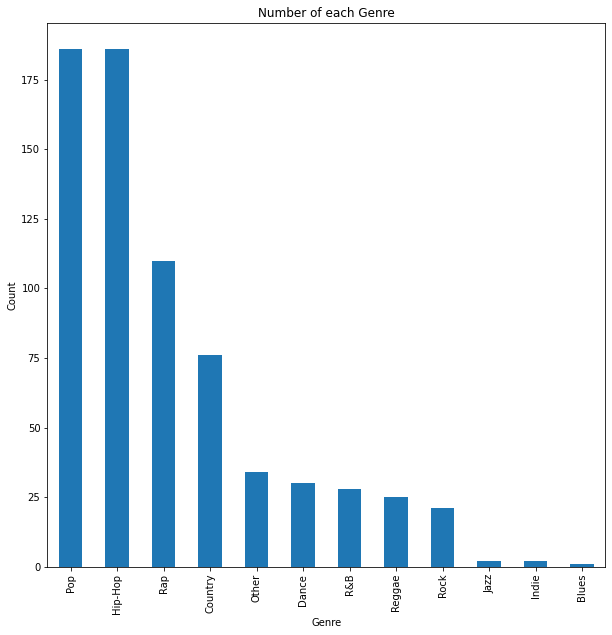

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Makes the bargraph.
ax = df2['Artist_Genres'].value_counts().plot(kind='bar', figsize = (10, 10))
plt.title("Number of each Genre")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

Here we see we found 11 of the 12 genres in the dataset given our method of selection. 

# Unsupervised Learning

To begin the analysis, let's examine whether genres from the Billboard Top 100 can be easily grouped by their musical qualities even without being given the correct labels. We'll use unsupervised learning techniques to examine how well the data is clustered into different genres. 

## K-Means Clustering

The first clustering method will be a standard K-Means clustering algorithm. Given a hyperparameter K, this algorithm will randomly place K centroids and adjust them to best separate the data into K clusters. A good clustering is defined by a small error between a centroid and members of its cluster and a large distance bewteen centroids. 

The first step is to choose the K hyperparameter. As shown above, there are actually 11 genres to classify, so K of 11 would make sense. But let's see if a hyperparameter curve will show that there should be 11 centroids. This curve will plot a clustering metric for the data over different K values. The Silhouette score is the metric used to evaluate the clustering in this case. This metric measures both the error within the cluster and the distance between clusters. All scores are within [-1, 1] with a higher score indicating tight clusters that a very well-separated, while a negative score indicates overlapping clusters. A score close to 0 indicate the data is uniformly distributed throughout the Euclidean space, meaning clusters do not overlap but do not form distinct groups either. 

More informationn about the silhouette score can be found here: 
https://arxiv.org/abs/1905.05667
https://www.sciencedirect.com/science/article/pii/0377042787901257 

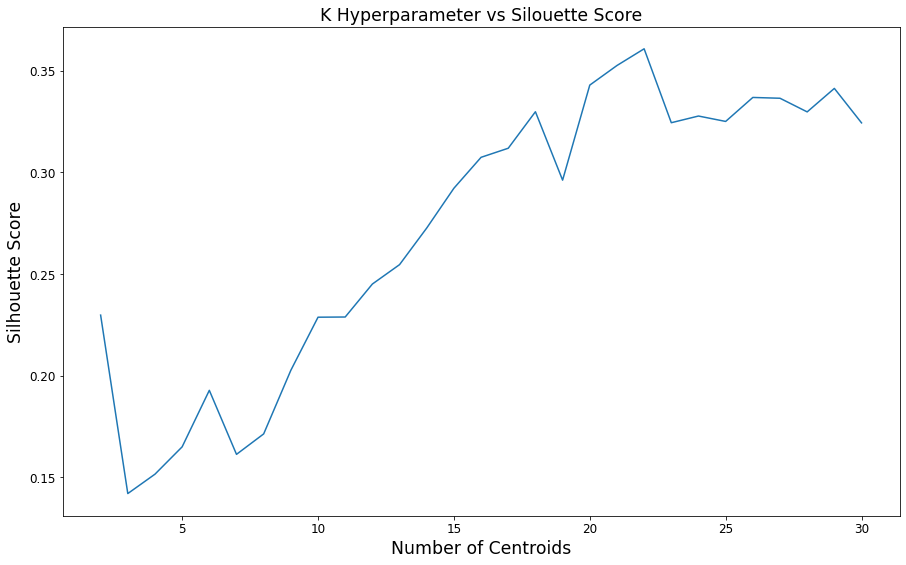

In [13]:
import sklearn.model_selection as sk_ms
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# plots a hyperparameter curve for the passed input data for the k values passed
# the evaluation metric will be the silhouette score, which scores models based
# on the error within a cluster and the separation between clusters
def kMeansHyperparameterCurve(X, kVals):
    results = []

    for k in kVals:
        model = KMeans(k)

        model.fit(X)

        results.append(metrics.cluster.silhouette_score(X, model.labels_))

    fig = plt.figure(1, (15, 9))

    plt.title("K Hyperparameter vs Silouette Score", fontsize='xx-large')
    plt.xlabel("Number of Centroids", fontsize='xx-large')
    plt.ylabel("Silhouette Score", fontsize='xx-large')
    plt.xticks(fontsize="large")
    plt.yticks(fontsize="large")

    plt.plot(kVals, results)
    plt.show()

# select columns of interest (those related to musical qualities) for input data
X = df2[["Duration", "Loudness", "Tempo", "Tempo_Confidence", "Meter", "Meter_Confidence", "Key", "Key_Confidence", "Mode", "Mode_Confidence", "Acousticness", "Danceability", "Energy", "Instrumentalness", "Liveness", "Speechiness", "Valence"]]

# generate a one-hot-encoding for each categorical variable
X = pd.get_dummies(X, columns=["Meter", "Key", "Mode"])

numeric_cols = ["Duration", "Loudness", "Tempo", "Tempo_Confidence", "Meter_Confidence", "Key_Confidence", "Mode_Confidence", "Acousticness", "Danceability", "Energy", "Instrumentalness", "Liveness", "Speechiness", "Valence"]
# normalize the numberical variables
X[numeric_cols] = X[numeric_cols].apply(lambda col : (col - col.min()) / (col.max() - col.min()), axis = 0)

# plot a curve for integer Ks in [2, 30]
kMeansHyperparameterCurve(X, range(2, 31))

A K of 26 has the best silhouette score of about 0.375, with 11 having a relatively low score of around 0.25. Both of these scores are not incredibly close to 0, but are close enough to indicate that the data does not separate very well into distinct groups. There is some separation, but not so much that there are well-defined grouping for the algorithm to latch onto. If this is the case, then it is unlikely that any accurate genre groupings can be generated based on a distance metric. 

Just to be sure, let's take a look at how a K-Means with K = 11 groups, for each of the different genres. To measure this, a contingency matrix that displays the number of entries with each label in each genre can be generated using the pandas crosstab function. This can then be displayed graphically using a heatmap. A good clustering of the genres would mean that each genre is concentrated within one label and that label is different for each genre. 

Silhouette Score for 12 centroids: 
0.2464727880101641


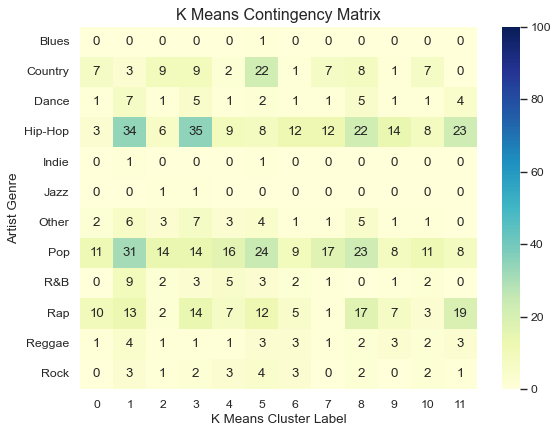

In [14]:
import seaborn as sns; sns.set()

Y = df2["Artist_Genres"]

k = len(pd.unique(Y)) # set k to be actual number of genres

model = KMeans(k)

model.fit(X)

# show silhoetter score for model
print(f"Silhouette Score for {k} centroids: ")
print(metrics.cluster.silhouette_score(X, model.labels_))

# generate contingency matrix of genres vs. labels
contigency = pd.crosstab(Y, model.labels_, rownames=["Artist Genre"], colnames=["K Means Cluster Label"])

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.clf()

plt.title("K Means Contingency Matrix", fontsize='large')

# display as a heatmap
res = sns.heatmap(contigency, annot=True, fmt='d', cmap="YlGnBu", vmin=0.0, vmax=100.0)

plt.show()

And now with the optimal k = 26 based on the Silhoette Score. 

Silhouette Score for 26 centroids: 
0.3367212771822032


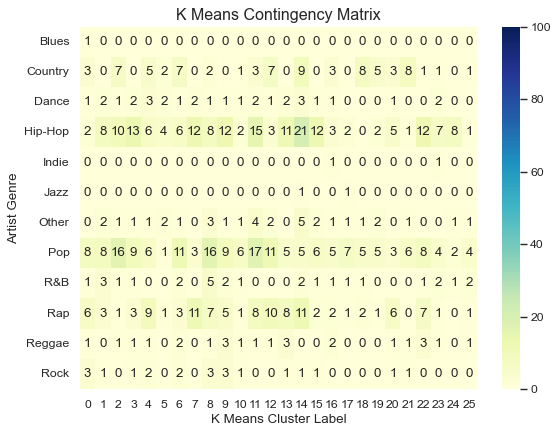

In [15]:
import seaborn as sns; sns.set()

Y = df2["Artist_Genres"]

k = 26 # set k to be optimal k from hyperparameter curve

model = KMeans(k)

model.fit(X)

print(f"Silhouette Score for {k} centroids: ")
print(metrics.cluster.silhouette_score(X, model.labels_))

contigency = pd.crosstab(Y, model.labels_, rownames=["Artist Genre"], colnames=["K Means Cluster Label"])

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.clf()

plt.title("K Means Contingency Matrix", fontsize='large')

res = sns.heatmap(contigency, annot=True, fmt='d', cmap="YlGnBu", vmin=0.0, vmax=100.0)

plt.show()

Examining the heat maps, there are a couple of important things to note. The first is that very few genres with a sizable (> 10) number of examples were very well concentrated within a single label. For k = 11, the only sizeable genre with any noticeable grouping was Country, which had more than half of its examples in label 8, although pop and rap/hip-hop dominated that label. For k = 26, this grouping is entirely destroyed, showing that a higher Silhouette Score does not necessarily lead to a better grouping in terms of genres. It is possible that the Silhouette Score is correctly finding better clustering within the data, but this clustering may be based on a property different from the genre. It seems as though none of the genres are very well-separated from the others, just as the silhouette score indicated. 

The other observation worthy of note is that the classes are not evenly-sized. There are very few observations for genres like Blue and Jazz, and very many for Pop and Rap/Hip-Hop. K-Means does not perform very well on datasets that do not have an even cluster size, so another clustering method may be more suitable for this task. 

## Mean-Shift Clustering

Mean-Shift Clustering is another clustering algorithm that, rather than having a set number of clusters, seeks to find the most dense part of a region within a search space. This makes the algorithm much more effective with uneven cluster sizes and smooth densities of samples. However, it does make the algorithm more susceptible to outliers since the number of centroids is not controlled and outliers can form their own "dense" regions. Since our problem seems to suffer from both a more uniform distribution of points and very uneven cluster sizes, this algorithm should see some improvement over K-Means.

The hyperparameter that Mean-Shift Clustering offers is the bandwidth of the kernel, which controls the size of the search space for the centroids. There are many factors to take into account when choosing this hyperparameter, but for simplicity's sake we will just consider one: the Silhouette Score. 

For more information, see these sources:

https://scikit-learn.org/stable/modules/clustering.html#mean-shift
https://www.geeksforgeeks.org/ml-mean-shift-clustering/
https://ieeexplore.ieee.org/document/1000236

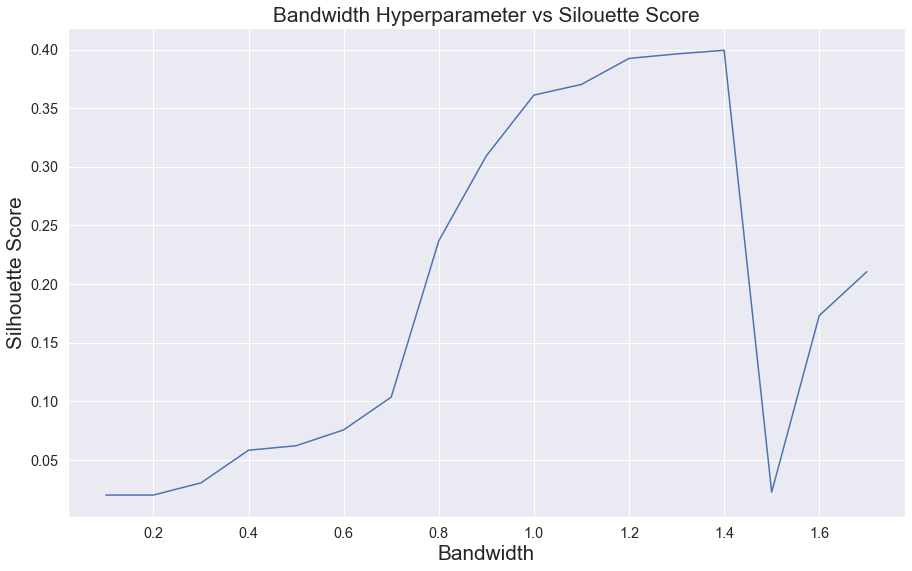

In [16]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
import numpy as np

# plots a hyperparameter curve for the passed input data for the bandwidth values passed
# the evaluation metric will be the silhouette score, which scores models based
# on the error within a cluster and the separation between clusters
def meanShiftHyperparameterCurve(X, bandVals):
    scores = []

    for band in bandVals:
        model = MeanShift(bandwidth=band)

        model.fit(X)

        scores.append(metrics.cluster.silhouette_score(X, model.labels_))

    fig = plt.figure(1, (15, 9))

    plt.title("Bandwidth Hyperparameter vs Silouette Score", fontsize='xx-large')
    plt.xlabel("Bandwidth", fontsize='xx-large')
    plt.ylabel("Silhouette Score", fontsize='xx-large')
    plt.xticks(fontsize="large")
    plt.yticks(fontsize="large")

    plt.plot(bandVals, scores)
    plt.show()    

# generate curve for 
meanShiftHyperparameterCurve(X, np.linspace(0.1, 1.7, 17))

This hyperparameter curve shows that Mean-Shift is able to acheive a higher silhouette score than K-Means as expected. However, 0.4 is still not a very high Silhouette Score. Furthermore, just as was the case with K-Means, this does not necessarily mean that the clustering achieved corresponds well to the genre classifications. This is even more so the case with Mean-Shift, since the number of clusters is not controlled. 

Given this information, let's run Mean-Shift with the bandwidth that maximized the Silhouette score and see how well the labels correspond to the classes. 

Silhouette Score for bandwidth 1.4: 
0.3993860514484905


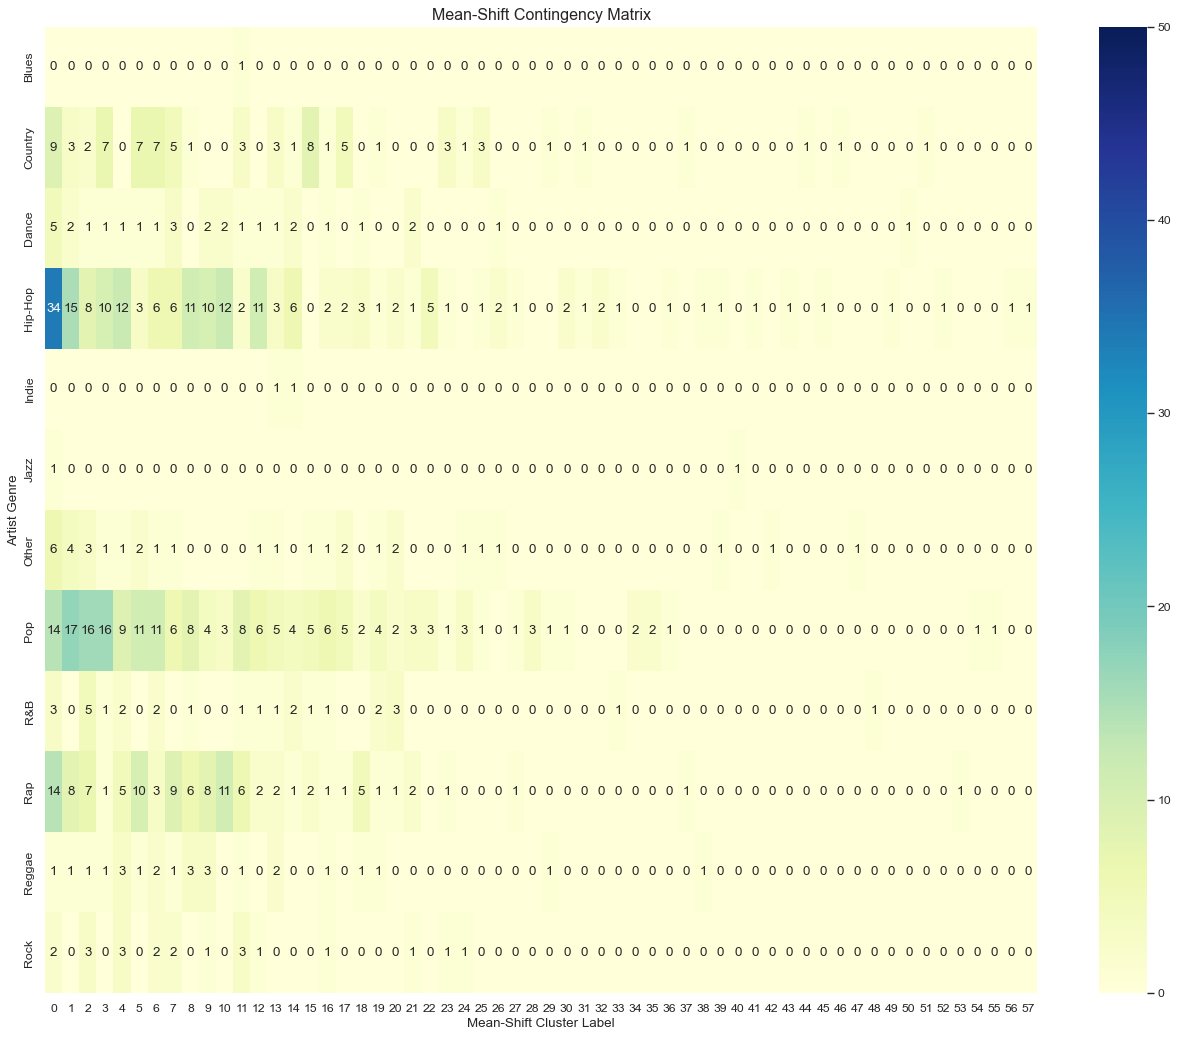

In [17]:
band = 1.4
model = MeanShift(bandwidth=band)

model.fit(X)

print(f"Silhouette Score for bandwidth {band}: ")
print(metrics.cluster.silhouette_score(X, model.labels_))

contigency = pd.crosstab(Y, model.labels_, rownames=["Artist Genre"], colnames=["Mean-Shift Cluster Label"])

fig = plt.figure(num=None, figsize=(20, 16), dpi=80, facecolor='w', edgecolor='k')

plt.clf()

plt.title("Mean-Shift Contingency Matrix", fontsize='large')

res = sns.heatmap(contigency, annot=True, fmt='d', cmap="YlGnBu", vmin=0.0, vmax=50.0)

plt.show()

Even though Mean-Shift is able to achieve a higher Silhouette score, it's grouping of genres is not much improved. This is in large part due to the algorithm creating a much larger number of clusters because of outliers creating very small clusters. Even Country, a genre K-Means was able to group fairly well under a single label, is not well-classified using Mean-Shift. So K-Means seems to be a much better clustering algorithm for the data we have despite Mean-Shift's advantages. 

## K-Means Revisited

Both K-Means and Mean-Shift have shown significant flaws when used on the current dataset. However, K-Means showed some potential when classifing one of the larger genres, despite its lower Silhouette Score. Since K-Means may struggle with the imbalanced sizes of classes in the dataset, focusing on only the largest classes with fewer clusters may help the algorithm with its separation. Now we'll examine how the algorithm performs with only a few of the most popular genres. 

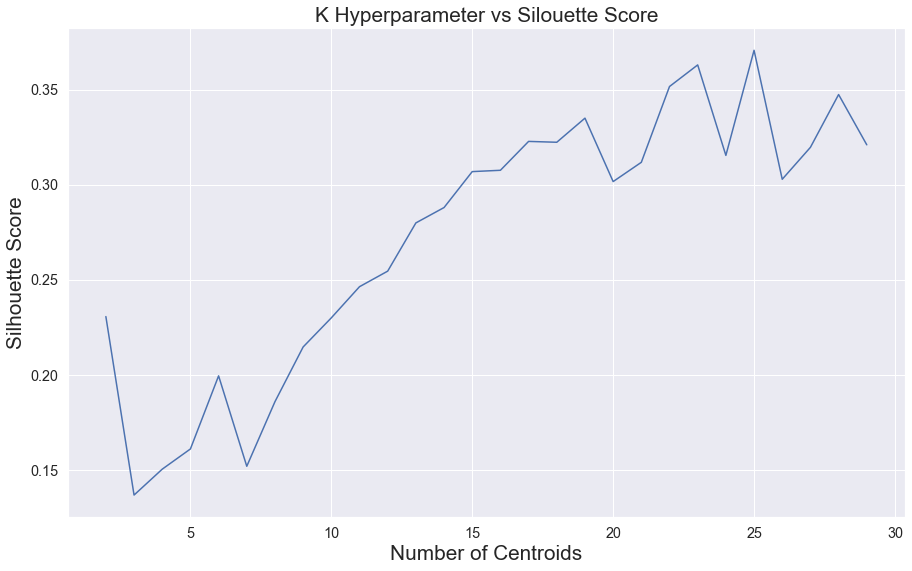

In [25]:
# select the most popular genres
toSelect = ["Pop", "Rap", "Hip-Hop", "Country"]
reduced = df2.loc[df2["Artist_Genres"].isin(toSelect)]

# generate the new input data similar to the full dataset
X2 = reduced[["Duration", "Loudness", "Tempo", "Tempo_Confidence", "Meter", "Meter_Confidence", "Key", "Key_Confidence", "Mode", "Mode_Confidence", "Acousticness", "Danceability", "Energy", "Instrumentalness", "Liveness", "Speechiness", "Valence"]]
X2 = pd.get_dummies(X2, columns=["Meter", "Key", "Mode"])

numeric_cols = ["Duration", "Loudness", "Tempo", "Tempo_Confidence", "Meter_Confidence", "Key_Confidence", "Mode_Confidence", "Acousticness", "Danceability", "Energy", "Instrumentalness", "Liveness", "Speechiness", "Valence"]

X2[numeric_cols] = X2[numeric_cols].apply(lambda col : (col - col.min()) / (col.max() - col.min()), axis = 0)

# plot a curve for 
kMeansHyperparameterCurve(X2, np.array(range(2, 30)))

The Silhouette Score has not changed much, suggesting the separation has not improved. Let's see how the genres were grouped. 

Silhouette Score for 4 centroids: 
0.15044484049574397


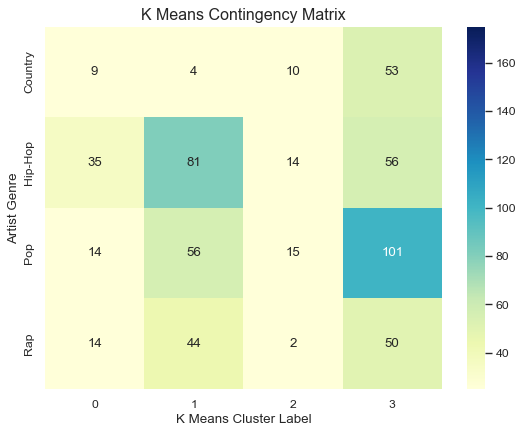

In [26]:
Y2 = reduced["Artist_Genres"]

k = len(pd.unique(Y2))

model = KMeans(k)

model.fit(X2)

print(f"Silhouette Score for {k} centroids: ")
print(metrics.cluster.silhouette_score(X2, model.labels_))

contigency = pd.crosstab(Y2, model.labels_, rownames=["Artist Genre"], colnames=["K Means Cluster Label"])

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.clf()

plt.title("K Means Contingency Matrix", fontsize='large')

res = sns.heatmap(contigency, annot=True, fmt='d', cmap="YlGnBu", vmin=25.0, vmax=175.0)

plt.show()

The reduction in the number of classes seems to have caused Country to group more into a single class, though the class is still dominated by Rap. None of the labels seem to correspond to any particular genre, and most saturation seems to stem from the imbalance between the classes. 

## Conclusion

Overall, these clustering algorithms have not been successful at grouping songs by genre based on their musical qualities. Using a distance-based approach does not seem to yield the necessary amount of separation between genres making it so that a single genre can be spread across many groups as it overlaps with other genres in the Euclidean space. While the Silhouette Score indicates that there is some separation, this separation may not be based on the genres per se, but rather another attribute of the music, such as the artist who wrote it or the year it was made in. This is a limitation of unsupervised learning, which does not specify exactly what attribute is being classified/optimized. 

That being said, the genres for each song are available with this data, so supervised learning is a good next step for analyzing this data and finding useful insights. 

## Supervised Learning

After the results of unsupervised learning, we tried supervised learning to see if it would be possible to learn specfic traits about each genre. Since we have the labels for each data point already (the labels are the genres for each song), we can easily apply supervised learning algorithms to the data set.  

### One Versus All MultiClass

For this project, we decided to use a One Versus All classifier for all of the 12 broad genre categories utilizing a Support Vector Classification for each of the classifiers. We initially decided to use a OVA approach for the multi class classifier instead of one versus one as the goal is to distinguish one genre from all other genres. As a default method, one versus all also makes sense as it would involve only 12 classifiers for this problem as opposed to the 66 needed for a one versus one approach. SVC is a type of binary classifier that works by attempting to generate a hyperplane that divides an n-dimensional space into two classes. This is done as a convex optimization problem so as opposed to epochs or batch sizes, the relevant hyperparmeters the max iterations for the solver (defaults to no limit) and the tolerance for convergence (which defaults to e^-3). For this OVA multiclass classifier, we again used the built in functionality provided by the sklearn libraries.

In [36]:
# Import libraries for supervised learning
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score

def prepare_data(df, split=0.75):
    df = df[["Duration", "Loudness", "Tempo", "Tempo_Confidence", "Meter", "Meter_Confidence", "Key", "Key_Confidence", "Mode", "Mode_Confidence", "Acousticness", "Danceability", "Energy", "Instrumentalness", "Liveness", "Speechiness", "Valence", "Artist_Genres"]]
    # Generate a one-hot-encoding for each categorical variable
    df = pd.get_dummies(df, columns=["Meter", "Key", "Mode"])
    # normalize the numberical variables
    numeric_cols = ["Duration", "Loudness", "Tempo", "Tempo_Confidence", "Meter_Confidence", "Key_Confidence", "Mode_Confidence", "Acousticness", "Danceability", "Energy", "Instrumentalness", "Liveness", "Speechiness", "Valence"]
    df[numeric_cols] = df[numeric_cols].apply(lambda col : (col - col.min()) / (col.max() - col.min()), axis = 0)
    # Split the data into train and test splits
    train, test = sk_ms.train_test_split(df, train_size=split)
    
    # Generate the test x and y values
    test_x = test.drop(columns=["Artist_Genres"])
    test_y = test[["Artist_Genres"]]

     # Generate the test x and y values
    train_x = train.drop(columns=["Artist_Genres"])
    train_y = train[["Artist_Genres"]]
    return train_x.to_numpy(), train_y.to_numpy(), test_x.to_numpy(), test_y.to_numpy()

def fit_OVA(train_x, train_y, test_x, test_y, avg='weighted', disp_classes=False):
    # Create the classifier
    clf = OneVsRestClassifier(SVC()).fit(np.array(train_x), np.array(train_y))
    # Make predictions on the training data and commpute the training f_1 scores
    train_predict = clf.predict(train_x)
    train_f1 = f1_score(train_y, train_predict, average=avg)
    # Make predictions on the test data and commpute the test accuracy
    test_predict = clf.predict(test_x)    
    test_f1 = f1_score(test_y, test_predict, average=avg)
    # Display list of classes if desired
    if disp_classes:
        print(clf.classes_)
    # Return the training and test accuracies
    return train_f1, test_f1

# Read in the Spotify and Billboard data combined
df = pd.read_csv("csv/spotify_data_2022.csv").iloc[:, 1:].dropna().apply(lambda x: group_genres(x) if x.name == 'Artist_Genres' else x, axis=0)

# Average f1 results
train_f1_scores = []
test_f1_scores = []
for i in range(0, 100):
    train_x, train_y, test_x, test_y = prepare_data(df)
    train_f1, test_f1 = fit_OVA(train_x, train_y, test_x, test_y)
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)

# Print the accuracies
print("Average OVA F-1 Score over 100 Iterations")
print("Lowest Training F-1 Score:", min(train_f1_scores)*100)
print("Highest Training F-1 Score:", max(train_f1_scores)*100)
print("Average Training F-1 Score:", np.mean(train_f1_scores)*100)
print("Lowest Test F-1 Score:", min(test_f1_scores)*100)
print("Highest Test F-1 Score:", max(test_f1_scores)*100)
print("Average Test F-1 Score:", np.mean(test_f1_scores)*100)

Average OVA F-1 Score over 100 Iterations
Lowest Training F-1 Score: 65.23198363446359
Highest Training F-1 Score: 74.07501106091517
Average Training F-1 Score: 69.7379658105291
Lowest Test F-1 Score: 24.90560650161391
Highest Test F-1 Score: 44.293397531386326
Average Test F-1 Score: 35.30079619429781


To estimate the performance of the one versus all approach, we utilized a weighted F-1 score which examines the precision (the percentage of true positives classified over the labeled positives) and recall (the percentge of true positives classified over all of the positive samples in the dataset) of the model which provides a better estimate than general accuracy due to the imbalanced nature of our dataset. The [F-1 score](https://deepai.org/machine-learning-glossary-and-terms/f-score) is calculated as the number of true positives over the sum of true positives and the average of the false positives and false negatives which corresponds to 2 times the product of the precision and recall, divided by the sum of the precision and recall. F scores are typically used when false positives and false negatives should be weighted differently or when the data is imbalanced (like our data). After calculating all of the F-1 scores for each individual class they were all combined using a weighted average which weights each F-1 score based on the number of examples provided in the data. This was done to provide a more accurate understanding of how the approach worked given provided data as taking an unweighted average would have had resulted in drastically different results. Averaging the results of the OVA classifier over 100 diferent iterations yields lackluster results. While the ideal F-1 score would be 100% (meaning that both the precision and recall are 100%), the average test F-1 score was only 34.488% and the classifier was rarely right more than a third of the time. 

### One Versus One MultiClass

Due to the less-than-ideal findings using a one versus all approach, we now consider using a one versus one method. This might yeild better results as it may prove to be simpler to seperate music when only two genres are considered. Contrasting the findings of the one versus one approach to the one versus all approach may also reveal insights about the nature of our data.

In [ ]:
# Import libraries for supervised learning
from sklearn.multiclass import OneVsOneClassifier

def fit_OVO(train_x, train_y, test_x, test_y, avg='weighted', disp_classes=False):
    # Create the classifier
    clf = OneVsOneClassifier(SVC()).fit(np.array(train_x), np.array(train_y))
    # Make predictions on the training data and commpute the training f_1 scores
    train_predict = clf.predict(train_x)
    train_f1 = f1_score(train_y, train_predict, average=avg)
    # Make predictions on the test data and commpute the test accuracy
    test_predict = clf.predict(test_x)    
    test_f1 = f1_score(test_y, test_predict, average=avg)
    # Display list of classes if desired
    if disp_classes:
        print(clf.classes_)
    # Return the training and test accuracies
    return train_f1, test_f1

# Read in the Spotify and Billboard data combined
df = pd.read_csv("csv/spotify_data_2022.csv").iloc[:, 1:].dropna().apply(lambda x: group_genres(x) if x.name == 'Artist_Genres' else x, axis=0)

# Average f1 results
train_f1_scores = []
test_f1_scores = []
for i in range(0, 100):
    train_x, train_y, test_x, test_y = prepare_data(df)
    train_f1, test_f1 = fit_OVO(train_x, train_y, test_x, test_y)
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)

# Print the accuracies
print("Average OVA F-1 Score over 100 Iterations")
print("Lowest Training F-1 Score:", min(train_f1_scores)*100)
print("Highest Training F-1 Score:", max(train_f1_scores)*100)
print("Average Training F-1 Score:", np.mean(train_f1_scores)*100)
print("Lowest Test F-1 Score:", min(test_f1_scores)*100)
print("Highest Test F-1 Score:", max(test_f1_scores)*100)
print("Average Test F-1 Score:", np.mean(test_f1_scores)*100)

In [42]:
# Print the accuracies
print("Average OVA F-1 Score over 100 Iterations")
print("Lowest Training F-1 Score:", min(train_f1_scores)*100)
print("Highest Training F-1 Score:", max(train_f1_scores)*100)
print("Average Training F-1 Score:", np.mean(train_f1_scores)*100)
print("Lowest Test F-1 Score:", min(test_f1_scores)*100)
print("Highest Test F-1 Score:", max(test_f1_scores)*100)
print("Average Test F-1 Score:", np.mean(test_f1_scores)*100)

Average OVA F-1 Score over 100 Iterations
Lowest Training F-1 Score: 37.45096069870907
Highest Training F-1 Score: 46.37889129696009
Average Training F-1 Score: 41.737879042072365
Lowest Test F-1 Score: 19.156017732601534
Highest Test F-1 Score: 44.94553304203357
Average Test F-1 Score: 32.58619658265682


The F-1 scores using a one versus one approach were slightly worse, averaging an F-1 score of 32.586% compared to the previous F-1 scores of 34.488%. This may be due to the insufficient quantity of data as a low number of examples in each classifier could lead to very inaccurate classifiers between two genres. To examine in detail, we can look at the F-1 scores between each class before they are weighted.

In [39]:
train_x, train_y, test_x, test_y = prepare_data(df)
OVA_train_f1, OVA_test_f1 = fit_OVA(train_x, train_y, test_x, test_y, avg=None, disp_classes=False)
OVO_train_f1, OVO_test_f1 = fit_OVO(train_x, train_y, test_x, test_y, avg=None, disp_classes=False)
d = np.array([OVA_train_f1, OVO_train_f1])
df_f1 = pd.DataFrame(data=d, index=['OVA', 'OVO'], columns=['Blues', 'Country', 'Dance', 'Hip-Hop', 'Indie', 'Jazz', 'Other', 'Pop', 'R&B', 'Rap', 'Reggae', 'Rock'])
df_f1

c:\Users\lynch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Blues,Country,Dance,Hip-Hop,Indie,Jazz,Other,Pop,R&B,Rap,Reggae,Rock
OVA,0.0,0.794521,0.5,0.750000,0.5,1.0,0.651163,0.749064,0.736842,0.656934,0.965517,0.827586
OVO,0.0,0.576923,0.0,0.594005,0.0,0.0,0.071429,0.538667,0.000000,0.226804,0.000000,0.000000


As we can see, the F-1 scores for the OVO classifier have more zeroes for several classes, meaning that some of the classifiers had very few true positives, meaning that both the precision and recall for those classifiers were incredibly low if not 0%. This issue may be addressed if the data used contained more examples for each genre of music to provide a more robust defiinition for the qualities of a given genre.

## Conclusion

Ultimately these methods are fairly inaccurate which may indicate the issues with our data. For this type of classification its possible that in order to produce accurate results, a significant quantity of better quality data is needed. Obtaining data that contains more examples of each genre would greatly improve the quality of running these methods as the current dataset may be too imbalanced to produce accurate results. And providing more examples of each could better pinpoint the musical qualities that define each genre. Additionally if this project were to include more information pertaining to the lyrical content of the song or the musical instruments used (apart from whether or not the song is acoustic), that might provide more useful features for these algorithms to work on. But given the data that we acquired, we have to draw the conclusion that this data is not easily separable. So at least in the US Hot 100 songs of 2022, given metrics such as the key of a song, the tempo, the acousticness, and more, the generes are not incredibly distinct enough.

## Next Steps

Moving forward, the first step is to find better sources for more data. While the billboard charts were able to provide a significant number of songs to work with, unfortunately most of those songs belonged to only a handful of genres. The usage of F-1 scores was an attempt to mitigate the effect of such imbalanced data, but if we are to learn which aspects of a song can be used to distinguish the genre, having more examples of different genres would be preferable. It would also be useful to find other features that could be used in our algorithms. Finding a more robust method of determining the genre of a given song apart from using the artist's genre as a proxy may provide more accurate labels that to be using in training our models. Additionally, being able to gather information pertaining to a song's lyrics may provide important information that is relevant to categorizing genres. Similarly, being able to determine the timber of the instruments used in a track, to get a rough idea of the types of instruments used, could help distingush genres from each other. In the future, we would like to be able to generate accurate models that can also be applied to specific sub-genres and compare genre definitions from different years. It would be interesting to see how sub-genres of music differ and exactly how music genres have changed over time.  

